# ALS Project - Modeling

### Random Forest Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from regress_model import Linear_Model
from linear_plotting import *
from sklearn.cluster import KMeans

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def plot_model_parallel(y_test, y_predicted, units='units'):
    data = pd.DataFrame(y_test.values, columns=["test"])
    data['predicted']=y_predicted
    data['result']='result'
    parallel_coordinates(data, 'result',colormap=plt.get_cmap("Set2"))
    plt.title("Results of Model")
    plt.ylabel(units)
    plt.show()

### data = txt, death, riluzole, onset dates, demo

In [5]:
# load data
df = pd.read_csv("clean_data/tdrod.csv")

In [6]:
print(df.shape)
df.head()

(9640, 25)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,0,1,0,NaN,0,0,NaN,0.0,38.0,13870.0
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,0,0,0,NaN,1,0,NaN,0.0,52.0,18980.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN


### Add scale linear coeff

In [7]:
scale_assess = pd.read_csv("clean_data/scale_assess_slope.csv")

In [8]:
print(scale_assess.shape)
scale_assess.head()

(6537, 4)


,subject_id,scale,slope,intercept
0,329,original,-0.007092,40.084327
1,348,revised,-0.012720,46.428161
2,533,revised,-0.010940,48.231426
3,586,revised,-0.012535,48.000000
4,649,original,-0.020465,43.366399


In [9]:
# merge with previous data
df = df.merge(scale_assess, how='left', on='subject_id')

In [10]:
print(df.shape)
df.head()

(9640, 28)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days,scale,slope,intercept
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,NaN,0,0,NaN,0.0,38.0,13870.0,original,-0.007092,40.084327
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,NaN,1,0,NaN,0.0,52.0,18980.0,revised,-0.012720,46.428161
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


### Add the onset symptom data

In [11]:
symptom = pd.read_csv("clean_data/symptom_onset.csv")

In [12]:
print(symptom.shape)
symptom.head()

(2653, 32)


,subject_id,Symptom,Symptom_Other_Specify,Location,location,right_side,left_side,bilateral_side,loc_general,loc_trunk,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,649,WEAKNESS,NaN,FACIAL,facial,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,649,Speech,NaN,SPEECH,speech,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1234,Speech,NaN,TONGUE WEAKNESS,tongue weakness,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1234,Swallowing,NaN,ORAL PNARYNGIAL WEAKNESS,oral pnaryngial weakness,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2540,WEAKNESS,NaN,RIGHT LEG,right leg,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# merge with previous data
df = df.merge(symptom, how='left', on='subject_id')

In [14]:
print(df.shape)
df.head()

(10035, 59)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## clean up the data

In [15]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Age', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_trial_start_years', 'age_trial_start_days', 'scale',
       'slope', 'intercept', 'Symptom', 'Symptom_Other_Specify', 'Location',
       'location', 'right_side', 'left_side', 'bilateral_side', 'loc_general',
       'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech',
       'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands',
       'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory',
       'loc_neck_head', 'symptom', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fa

In [16]:
# limit to placebo subjects.
placebo = df[ df['Study_Arm']=='Placebo' ].copy()

In [40]:
placebo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 2 to 10033
Data columns (total 59 columns):
subject_id                          3004 non-null int64
Study_Arm                           3004 non-null object
Subject_Died                        1574 non-null float64
death_days_trail_start              1016 non-null float64
Subject_used_Riluzole               2409 non-null float64
Onset_Delta                         2522 non-null float64
Diagnosis_Delta                     1901 non-null float64
delta_onset_diag                    1901 non-null float64
death_day_since_onset               777 non-null float64
death_day_mean_delta                777 non-null float64
death_week                          777 non-null float64
death_month                         777 non-null float64
Age                                 2756 non-null float64
Ethnicity                           795 non-null object
Race_Americ_Indian_Alaska_Native    3004 non-null int64
Race_Asian                       

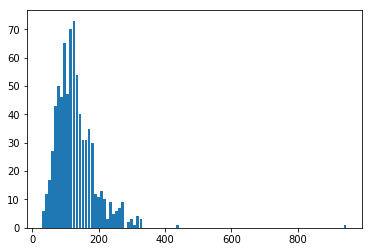

In [35]:
plt.hist(placebo['death_day_since_onset'], bins = 100, rwidth=0.9)
plt.show()

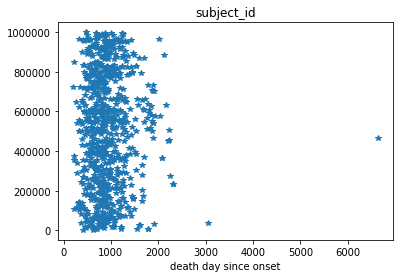

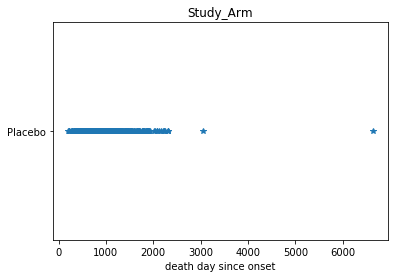

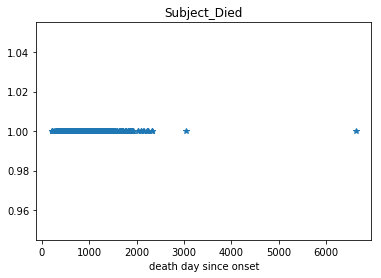

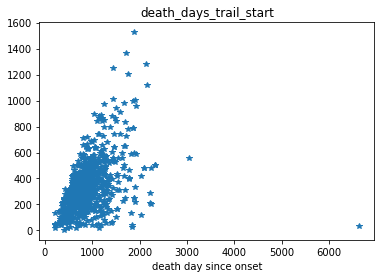

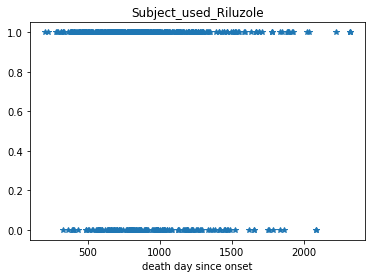

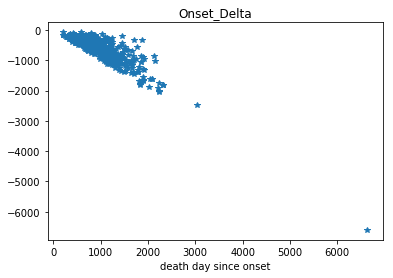

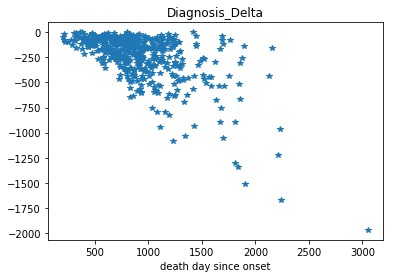

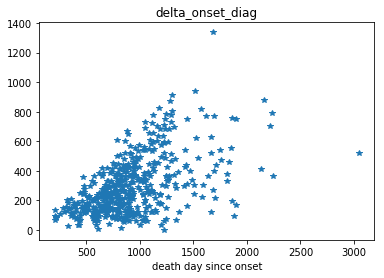

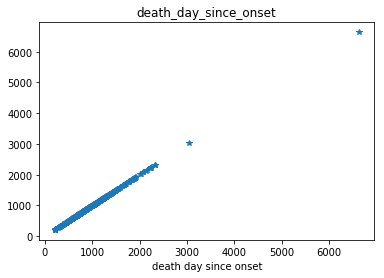

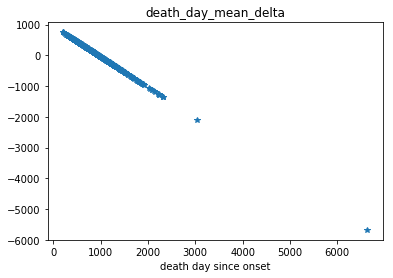

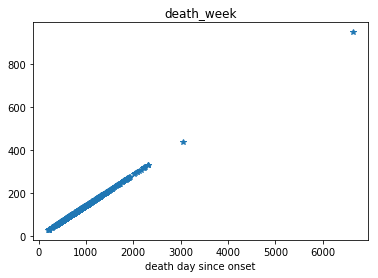

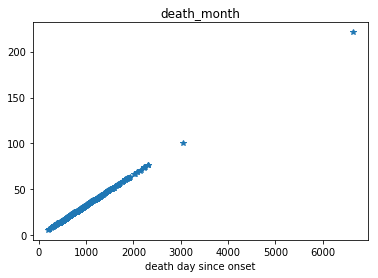

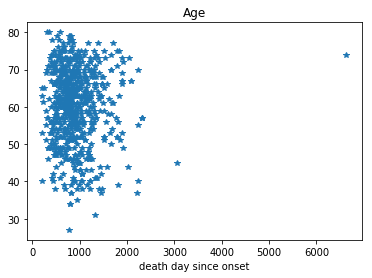

ValueError: could not convert string to float: 'Non-Hispanic or Latino'

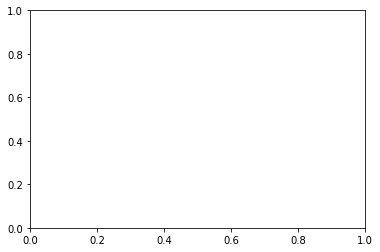

In [157]:
# test X with random rows
X1 = placebo[['Subject_used_Riluzole', 'age_trial_start_years', 'death_day_since_onset',
              'Race_Americ_Indian_Alaska_Native', 'Race_Asian', 'Race_Black_African_American',
              'Race_Hawaiian_Pacific_Islander', 'Race_Caucasian', 'slope' , 'death_day_mean', 
             'death_day_stdev']].copy()

X2 = placebo[['Subject_used_Riluzole', 'age_trial_start_years', 'death_day_since_onset',
              'Race_Americ_Indian_Alaska_Native', 'Race_Asian', 'Race_Black_African_American',
              'Race_Hawaiian_Pacific_Islander', 'Race_Caucasian', 'slope']].copy()

In [90]:
X3 = df[['Subject_used_Riluzole', 'age_trial_start_years', 'death_day_since_onset',
              'Race_Caucasian', 'slope', 'right_side', 'left_side', 'bilateral_side', 
              'loc_general',
       'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech',
       'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands',
       'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory',
       'loc_neck_head', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'symptom_swallowing', 'symptom_weakness']].copy()

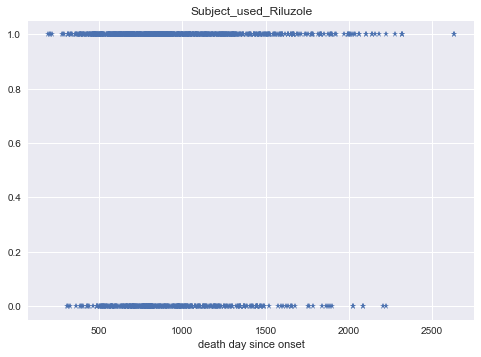

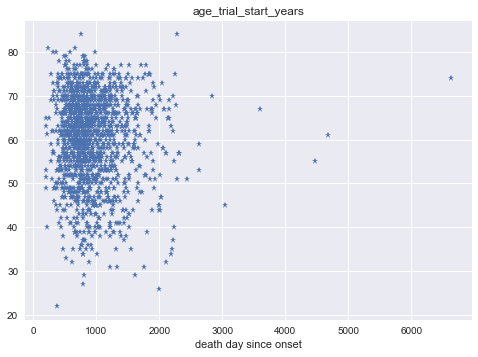

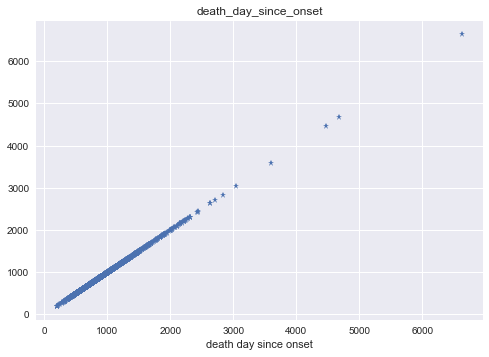

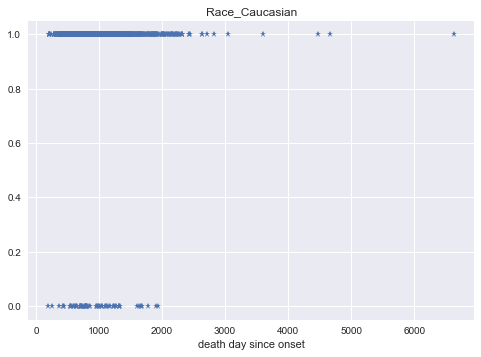

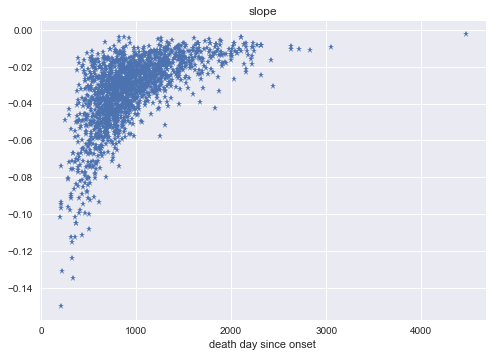

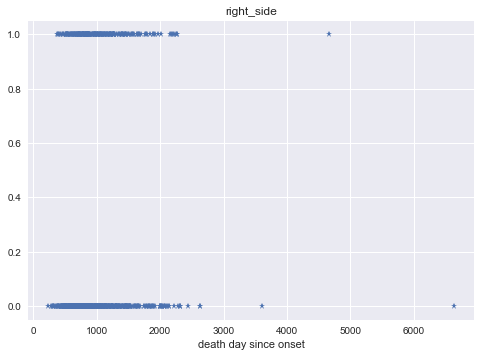

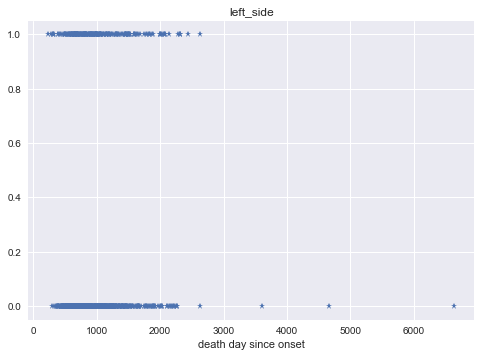

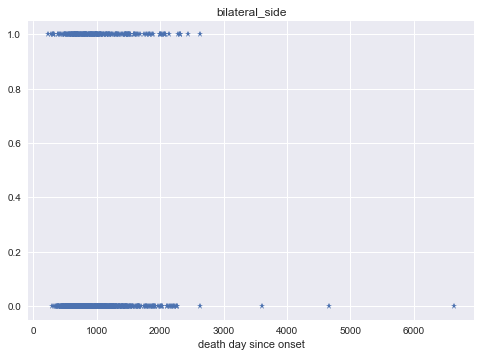

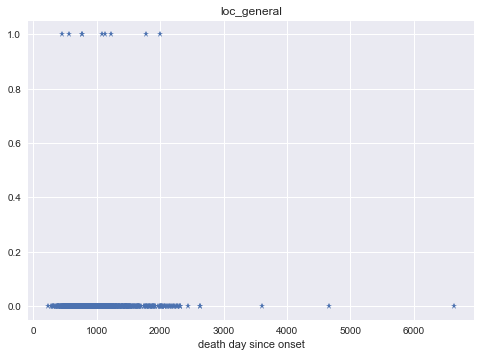

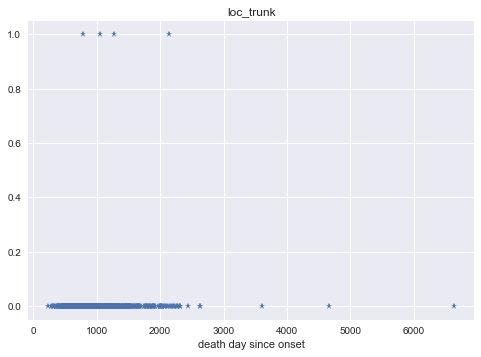

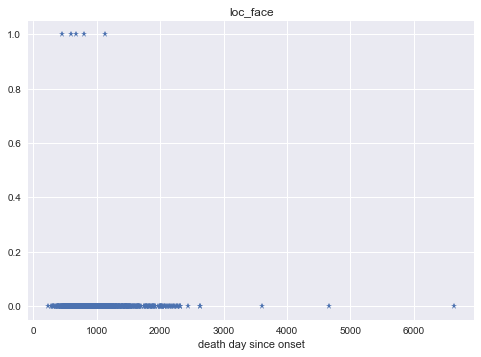

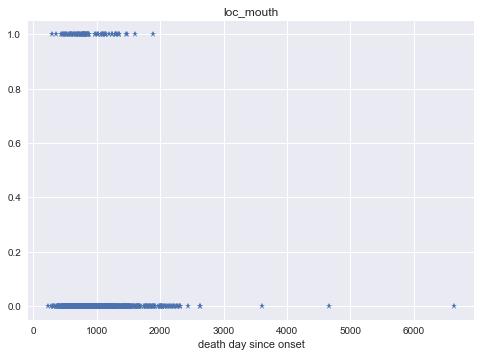

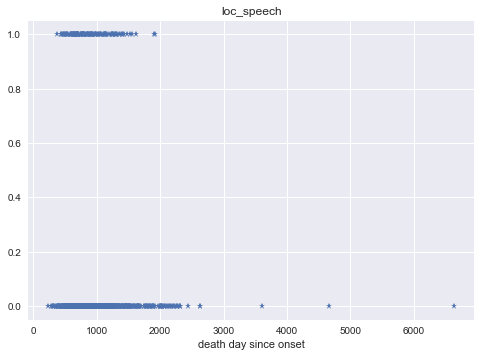

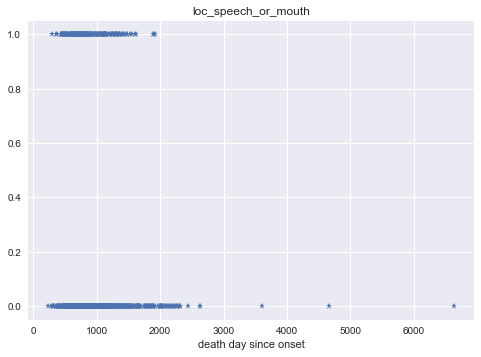

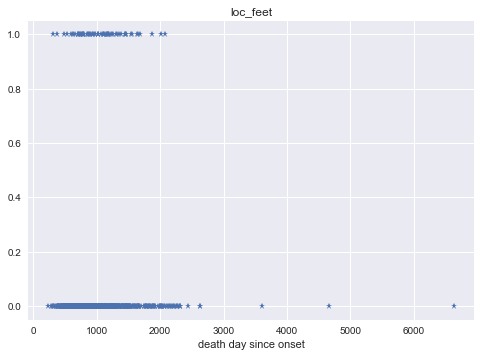

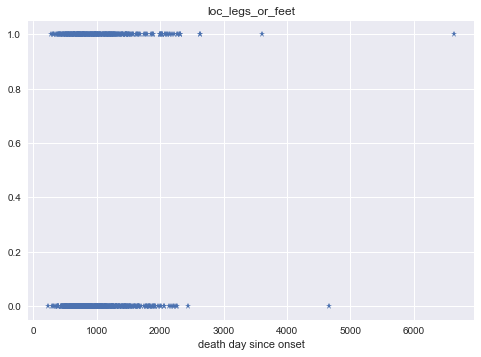

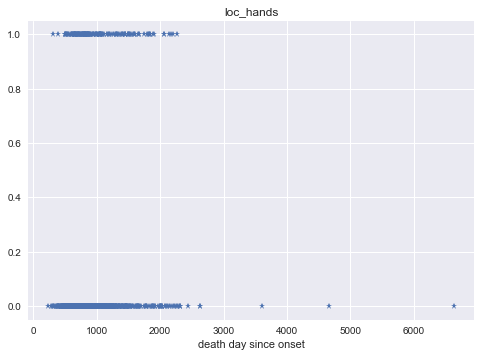

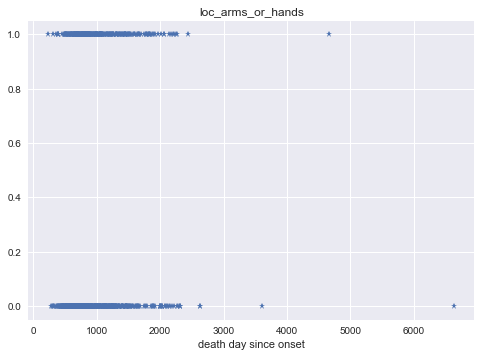

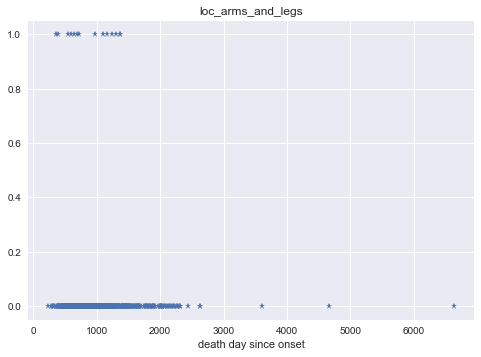

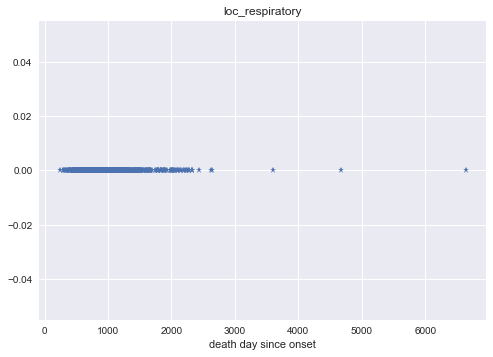

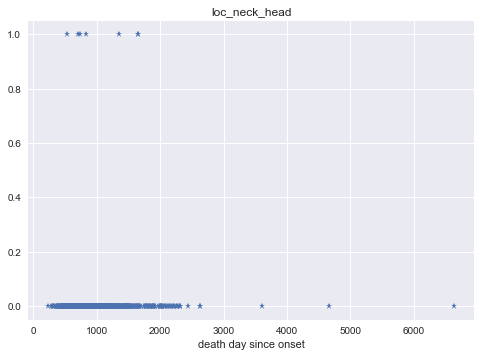

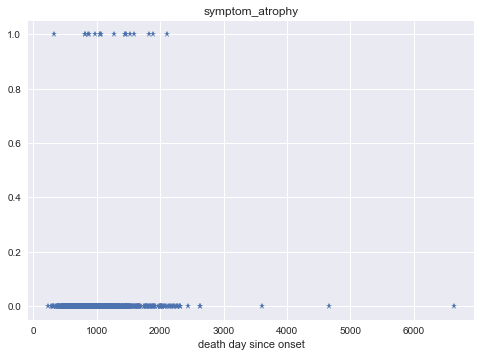

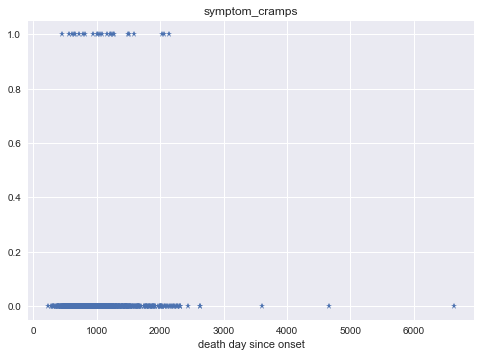

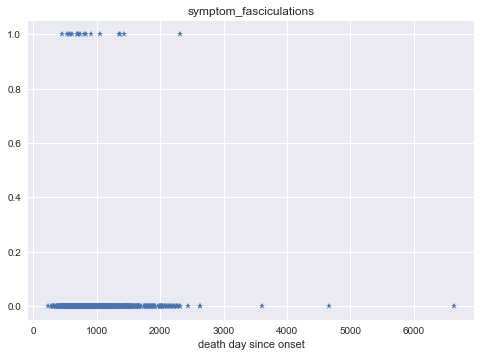

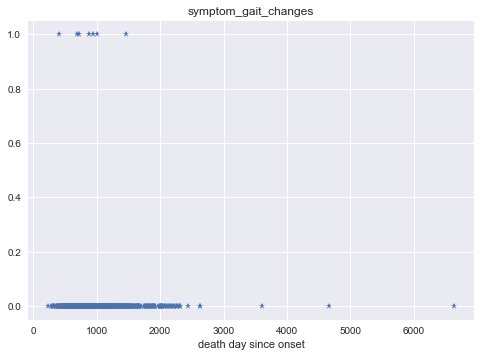

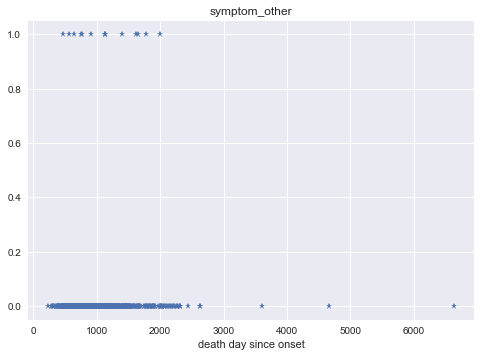

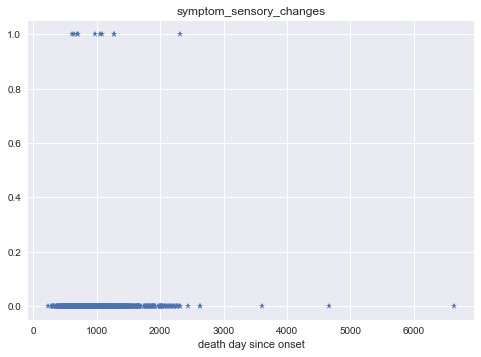

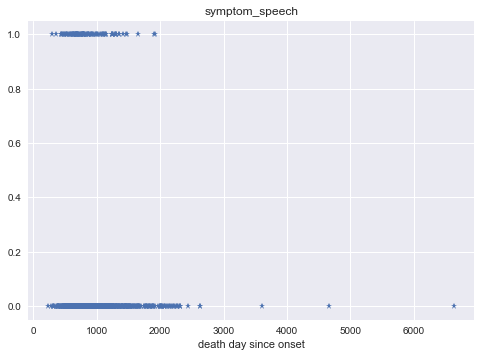

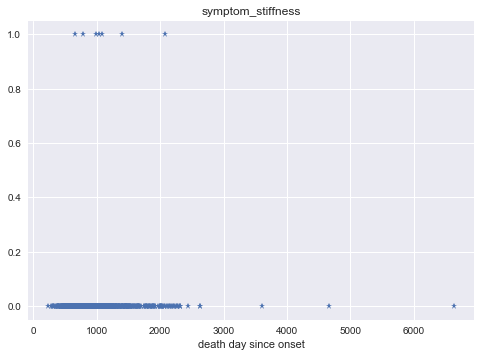

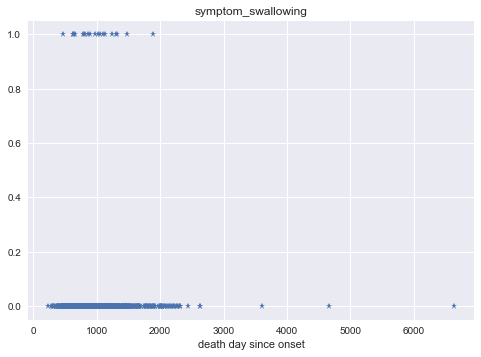

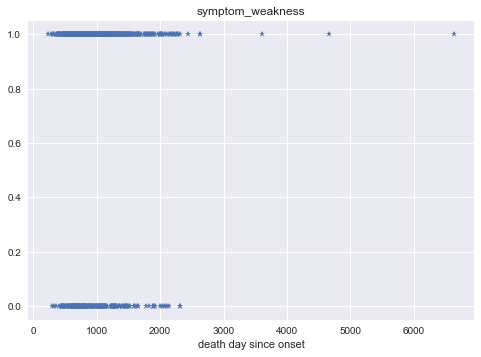

In [91]:
for feat in list(X3.columns):
    plt.plot( X3['death_day_since_onset'], X3[feat],'*')
    plt.title(feat)
    plt.xlabel("death day since onset")
    plt.show()

In [159]:
# get rid of the nans
X1.dropna(axis=0, inplace=True)

In [160]:
X2.dropna(axis=0, inplace=True)

In [96]:
X3.dropna(axis=0, inplace=True)

In [97]:
print(X3.shape)
X3.head()

(788, 31)


,Subject_used_Riluzole,age_trial_start_years,death_day_since_onset,Race_Caucasian,slope,right_side,left_side,bilateral_side,loc_general,loc_trunk,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
24,1.0,41.0,405.0,1,-0.053054,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34,1.0,60.0,624.0,1,-0.037167,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,0.0,69.0,825.0,1,-0.011764,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,1.0,68.0,585.0,1,-0.025766,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68,1.0,70.0,656.0,1,-0.012011,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
#X3.info()

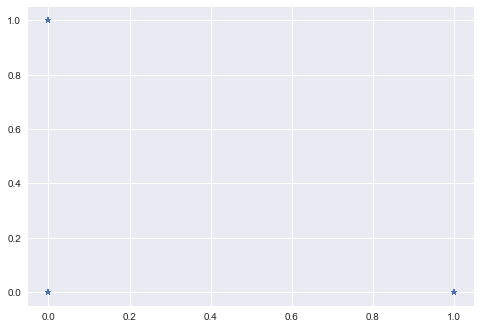

In [122]:
plt.plot(df['loc_'], df['loc_mouth'], '*')

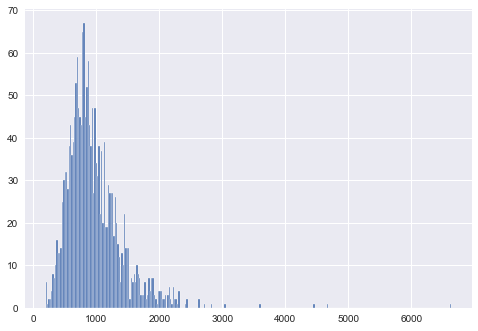

In [113]:
plt.hist(df['death_day_since_onset'], bins = 300, edgecolor='white')
plt.show()

#### split data

In [184]:
# assign target, features
y_1 = X1['death_day_since_onset']
X_1 = X1.drop('death_day_since_onset', axis=1)

In [185]:
# assign target, features
y_2 = X2['death_day_since_onset']
X_2 = X2.drop('death_day_since_onset', axis=1)

In [98]:
# assign target, features
y_3 = X3['death_day_since_onset']
X_3 = X3.drop('death_day_since_onset', axis=1)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.25, random_state=1234)


#### Random Forest 

In [100]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [101]:
# score - R2
model.score(X_test, y_test.values)

0.5854130807176712

In [102]:
#rf regressor model
# performs splits within class
params = {'criterion':'mse', 'random_state':1234}
lm = Linear_Model('random', X_3, y_3, params=params)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [103]:
lm.score

0.617130627582233

In [104]:
# predicted y values
y_predicted = model.predict(X_test)

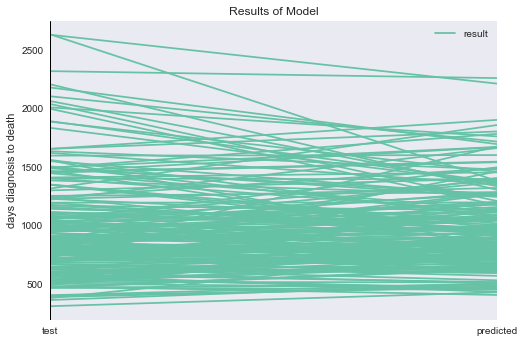

In [105]:
# plot the 
plot_model_parallel(y_test, y_predicted, 'days diagnosis to death')

In [107]:
# overview of test and predict data
data = pd.DataFrame(y_test.values, columns=["test"])
data['predicted']=y_predicted
data['result']='result'
print(data.shape)
data.head(10)

(197, 3)


,test,predicted,result
0,501.0,720.2,result
1,742.0,752.6,result
2,1001.0,662.6,result
3,1493.0,1669.8,result
4,1077.0,798.8,result
5,971.0,1130.6,result
6,865.0,1089.9,result
7,547.0,464.7,result
8,702.0,701.6,result
9,644.0,592.0,result


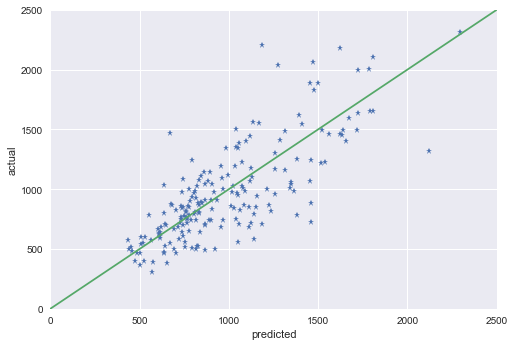

In [89]:
plt.plot(data['predicted'], data['test'], '*')
plt.ylabel("actual")
plt.xlabel("predicted")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.plot([0,2500], [0,2500])

In [72]:
# plot feature importances

## Linear Model

In [73]:
params = {'a':1}
lm = Linear_Model('linear', X_3, y_3, params)

In [74]:
lm.rmse

307.8776669671943

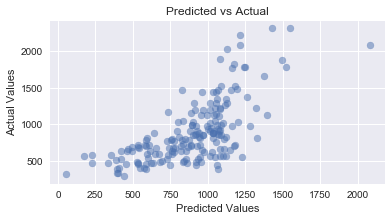

In [75]:
lm_plot(lm.predicted, lm.y_train)

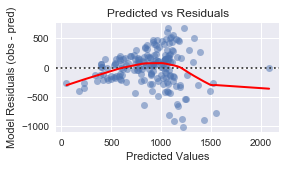

In [76]:
resid_plot(lm.predicted, lm.resid)

### Cluster analysis

In [284]:
# pick a limited number of columns from 'placebo'
placebo.columns
cluster_X = placebo[['Subject_used_Riluzole', 'Age', 'Race_Caucasian', 'sex', 
                     'slope', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(496, 6)


,Subject_used_Riluzole,Age,Race_Caucasian,sex,slope,death_day_since_onset
0,1.0,41.0,1,1.0,-0.053054,405.0
1,1.0,60.0,1,0.0,-0.037167,624.0
2,1.0,70.0,1,1.0,-0.012011,656.0
3,1.0,65.0,1,0.0,-0.040901,706.0
4,1.0,52.0,1,1.0,-0.006964,1781.0


In [285]:
cluster_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 6 columns):
Subject_used_Riluzole    496 non-null float64
Age                      496 non-null float64
Race_Caucasian           496 non-null int64
sex                      496 non-null float64
slope                    496 non-null float64
death_day_since_onset    496 non-null float64
dtypes: float64(5), int64(1)
memory usage: 23.3 KB


In [320]:
params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
          'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
          'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}

k=KMeans(**params).fit(cluster_X)

In [321]:
result = pd.DataFrame(k.labels_, columns=["kmeans_label"])
cluster_result = pd.concat([cluster_X, result], axis=1)
cluster_result.head()

,Subject_used_Riluzole,Age,Race_Caucasian,sex,slope,death_day_since_onset,kmeans_label
0,1.0,41.0,1,1.0,-0.053054,405.0,0
1,1.0,60.0,1,0.0,-0.037167,624.0,0
2,1.0,70.0,1,1.0,-0.012011,656.0,0
3,1.0,65.0,1,0.0,-0.040901,706.0,0
4,1.0,52.0,1,1.0,-0.006964,1781.0,1


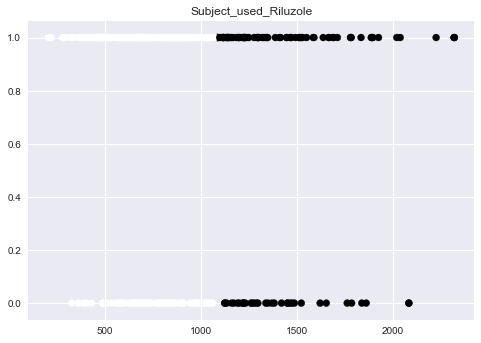

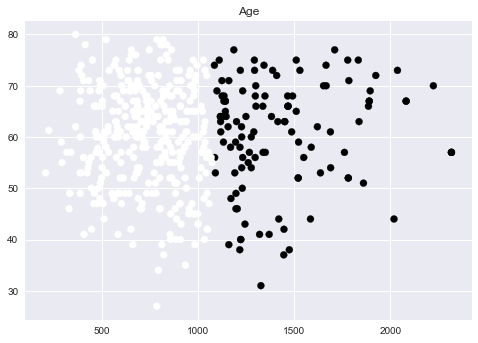

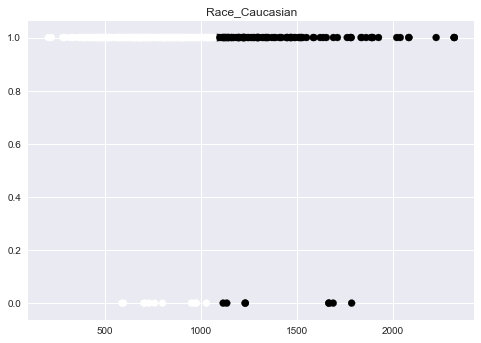

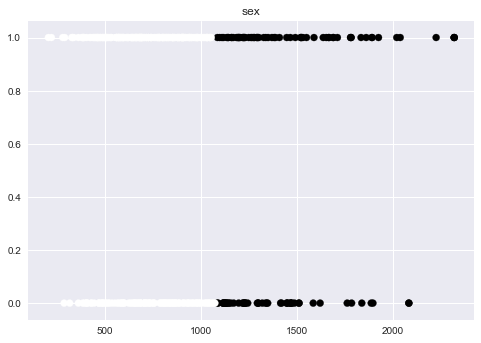

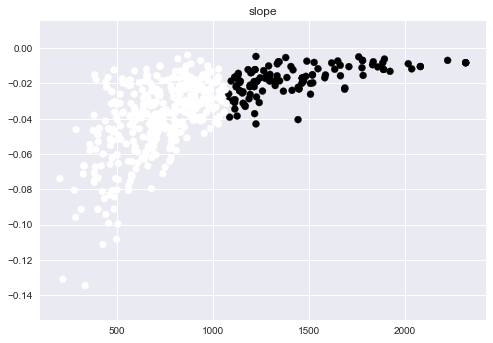

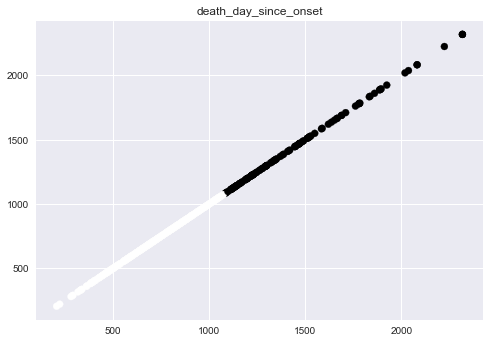

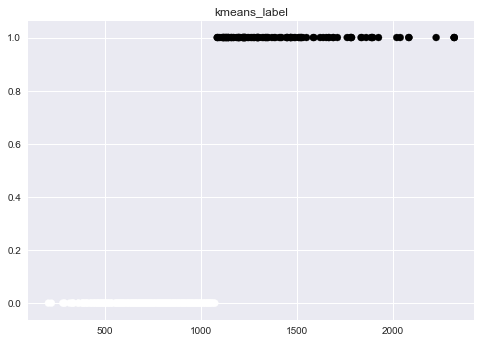

In [322]:
# plot the labels for each feature

for col in list(cluster_result.columns):
    plt.scatter(cluster_result['death_day_since_onset'], cluster_result[col], 
                c=cluster_result['kmeans_label'])
    plt.title(col)
    plt.show()